##  Imports 

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


##  1. CSV setup 

In [2]:
# 📂 Step 1: Load your raw sensor CSV (replace if needed)
train_path = '../test_csv/normal_2.csv'  # <-- UPDATE THIS PATH if needed
test_path = '../test_csv/motor_temp_low.csv'  # <-- UPDATE THIS PATH if needed

# 1️⃣ Load the raw file
df_train_raw = pd.read_csv(train_path)
df_test_raw = pd.read_csv(test_path)

# 2️⃣ Convert timestamps properly
df_train_raw['timestamp'] = pd.to_datetime(df_train_raw['timestamp'])
df_test_raw['timestamp'] = pd.to_datetime(df_test_raw['timestamp'])

# 3️⃣ Lock the row index for later tracing
df_train_raw['csv_index'] = df_train_raw.index
df_test_raw['csv_index'] = df_test_raw.index

# # 4️⃣ Print preview to confirm it's working
# print("📋 First 5 rows of raw CSV:")
# print(df_train_raw.head())

# # 5️⃣ Confirm the index alignment is safe
# index_check = all(df_train_raw['csv_index'] == df_train_raw.index)
# print(f"\n✅ csv_index aligned with DataFrame index? {index_check}")

In [3]:
# Load files
temp_df = pd.read_csv('../test_csv/motor_temp_high.csv')
power_df = pd.read_csv('../test_csv/motor_power_high.csv')
rpm_df   = pd.read_csv('../test_csv/motor_rpm_high.csv')
vib_df   = pd.read_csv('../test_csv/motor_viberation_high.csv')

# Parse timestamps
for df in [temp_df, power_df, rpm_df, vib_df]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Rename columns
temp_df = temp_df.rename(columns={'feature_0': 'temperature'})
power_df = power_df.rename(columns={'feature_0': 'power'})
rpm_df = rpm_df.rename(columns={'feature_0': 'rpm'})
vib_df = vib_df.rename(columns={'feature_0': 'vibration'})

# Merge on timestamp
df_merged = temp_df[['timestamp', 'state', 'temperature']]\
    .merge(power_df[['timestamp', 'power']], on='timestamp')\
    .merge(rpm_df[['timestamp', 'rpm']], on='timestamp')\
    .merge(vib_df[['timestamp', 'vibration']], on='timestamp')

df_merged['csv_index'] = df_merged.index

# 2️⃣ Filter for 'run' state
df_run = df_merged[df_merged['state'] == 'run'].copy()
feature_cols = ['temperature', 'power', 'rpm', 'vibration']
index_ref = df_run['csv_index'].values

In [4]:
# 📂 Step 2: Group multivariate data by state

# 1️⃣ Drop missing rows
df_train_clean = df_train_raw.dropna()
df_test_clean = df_test_raw.dropna()

# 2️⃣ Pivot data so each timestamp has all sensor readings as columns
df_train_pivot = df_train_clean.pivot(index="timestamp", columns="sensor", values="feature_0")
df_test_pivot = df_test_clean.pivot(index="timestamp", columns="sensor", values="feature_0")

# 3️⃣ Add state back to the pivoted data
# We'll assume each timestamp has only one state (i.e., consistent across sensors)
# So we extract state per timestamp by taking the first occurrence
state_map_train = df_train_clean.groupby("timestamp")["state"].first()
state_map_test = df_test_clean.groupby("timestamp")["state"].first()

# Merge state into pivoted data
df_train_pivot["state"] = state_map_train
df_test_pivot["state"] = state_map_test

# 4️⃣ Check available states in multivariate format
print("📊 Unique states in multivariate training data:")
print(df_train_pivot["state"].value_counts())
print(df_train_pivot.head())


📊 Unique states in multivariate training data:
run     35520
off      4500
idle     3150
Name: state, dtype: int64
sensor                  power       rpm  temperature  vibration state
timestamp                                                            
2025-04-07 00:00:00  4.626855  2.355440         22.0   7.854178   off
2025-04-07 00:01:00  4.136541  2.328874         22.0   7.535466   off
2025-04-07 00:02:00  5.120662  2.358879         22.0   7.746224   off
2025-04-07 00:03:00  4.400668  2.600601         22.0   7.582647   off
2025-04-07 00:04:00  4.868998  2.469488         22.0   7.469315   off


In [5]:
# 📂 Step 3: Normalize + sequence generation for 'run' state only (test)

# Select 'run' state group
run_df_train = df_train_pivot[df_train_pivot["state"] == "run"].drop(columns=["state"])
run_df_test = df_test_pivot[df_test_pivot["state"] == "run"].drop(columns=["state"])

# Normalize the feature_0 column
scaler = MinMaxScaler()
run_scaled_train = scaler.fit_transform(run_df_train)
run_scaled_test = scaler.transform(run_df_test)

def create_sequences_multivariate(data, window=20):
    sequences = []
    for i in range(len(data) - window + 1):
        seq = data[i:i+window]
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences
seq_len = 20
X = create_sequences_multivariate(run_scaled_train, window=seq_len)
Y = create_sequences_multivariate(run_scaled_test, window=seq_len)

In [6]:
# Parameters
seq_len = 20
batch_size = 128
epochs = 10
state_models = {}


In [7]:

# Function to create sequences
def create_sequences_multivariate(data, window=20):
    return np.array([data[i:i+window] for i in range(len(data) - window + 1)])

    
df_train_pivot_clean = df_train_pivot.dropna()
for state_name, group_df in df_train_pivot_clean.groupby("state"):
    print(f"\n🔧 Training model for state: {state_name}")

    # Drop 'state' column to isolate feature data
    group_features = group_df.drop(columns=["state"])

    # Normalize
    scaler = MinMaxScaler()
    group_scaled = scaler.fit_transform(group_features)

    # Sequence generation
    X_state = create_sequences_multivariate(group_scaled, window=seq_len)

    # Build model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_state.shape[1], X_state.shape[2]), return_sequences=False),
        RepeatVector(X_state.shape[1]),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_state.shape[2]))
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse')

    # Train
    model.fit(X_state, X_state, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    # Save model and scaler
    state_models[state_name] = {
        "model": model,
        "scaler": scaler
    }



🔧 Training model for state: idle
Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1489 - val_loss: 0.0373
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0371 - val_loss: 0.0296
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0283 - val_loss: 0.0232
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0223 - val_loss: 0.0203
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - val_loss: 0.0175
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0164 - val_loss: 0.0162

🔧 Training model for state: off
Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1405 - val_loss: 0.0333
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0288 - val_loss: 0.0218
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0202 - val_loss: 0.0166
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116 - val_loss: 0.0116

🔧 Training model for state: run
Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0666 - val_loss: 0.0083
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 9/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0065 - val_loss: 0.0067


In [11]:
all_results = []

seq_len = 20

def create_sequences_multivariate(data, window=20):
    return np.array([data[i:i+window] for i in range(len(data) - window + 1)])

# 1. Loop over each state in the test data
for state, group_df in df_test_pivot.dropna().groupby("state"):
    print(f"\n📌 Predicting for state: {state}")

    if state not in state_models:
        print(f"⚠️ Skipping state '{state}' — no trained model available.")
        continue

    model = state_models[state]["model"]
    scaler = state_models[state]["scaler"]

    # Drop state column to get features only
    X_test_state = group_df.drop(columns=["state"])

    # Normalize
    X_scaled = scaler.transform(X_test_state)

    # Sequence creation
    Y_state = create_sequences_multivariate(X_scaled, window=seq_len)

    # Predict
    Y_pred = model.predict(Y_state)
    errors = np.mean(np.abs(Y_pred - Y_state), axis=(1, 2))

    # Mode-based threshold
    hist, bin_edges = np.histogram(errors, bins=100)
    mode_index = np.argmax(hist)
    threshold = bin_edges[mode_index] * 1.5 # Adjust threshold as needed
    print(f"📊 Mode threshold for state '{state}': {threshold:.6f}")

    # Label anomalies
    is_anomaly = (errors > threshold).astype(int)

    # Map timestamps
    timestamps = group_df.index[seq_len - 1:]  # align with sequence ends

    # Store results
    result_df = pd.DataFrame({
        "timestamp": timestamps,
        "state": state,
        "reconstruction_error": errors,
        "threshold": threshold,
        "is_anomaly": is_anomaly
    })

    all_results.append(result_df)

# 2. Combine all state-specific results
final_results = pd.concat(all_results).sort_values("timestamp").reset_index(drop=True)


📌 Predicting for state: idle
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
📊 Mode threshold for state 'idle': 0.127257

📌 Predicting for state: off
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 Mode threshold for state 'off': 0.112227

📌 Predicting for state: run
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 Mode threshold for state 'run': 0.093286


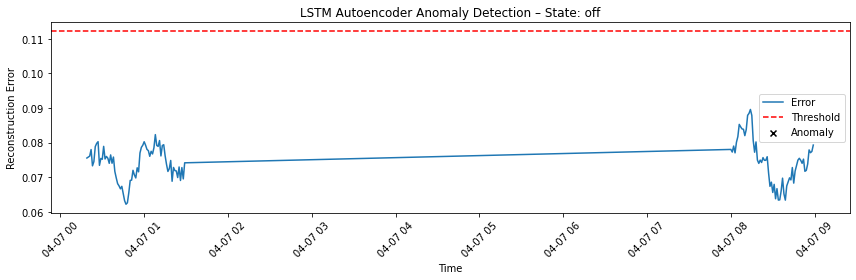

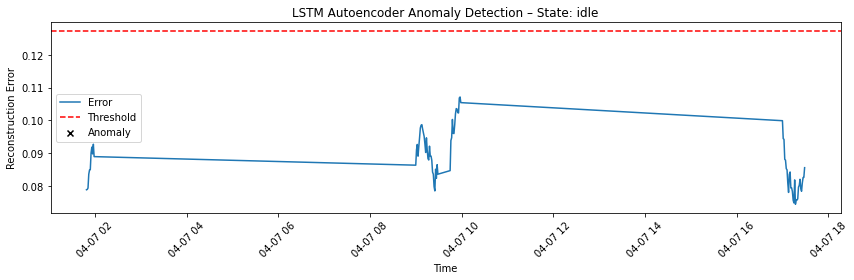

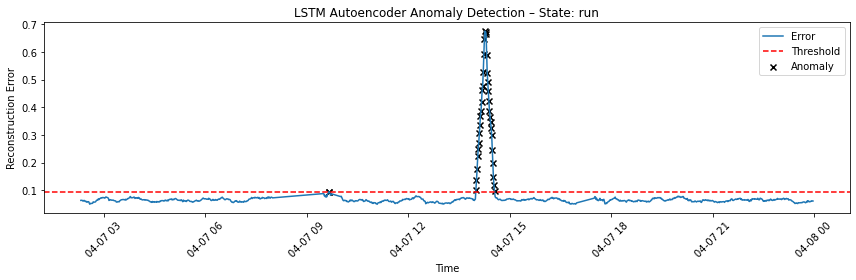

In [9]:
for state in final_results["state"].unique():
    subset = final_results[final_results["state"] == state]
    plt.figure(figsize=(12, 4))
    plt.plot(subset["timestamp"], subset["reconstruction_error"], label="Error")
    plt.axhline(y=subset["threshold"].iloc[0], color='red', linestyle='--', label="Threshold")
    plt.scatter(
        subset["timestamp"][subset["is_anomaly"] == 1],
        subset["reconstruction_error"][subset["is_anomaly"] == 1],
        color='black', marker='x', label='Anomaly'
    )
    plt.title(f"LSTM Autoencoder Anomaly Detection – State: {state}")
    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [12]:

# Save the trained model if not already saved
if 'model' in locals():
    model.save(f"../test_cases/saved_models/lstm_{state}.h5")
    print(f"✅ Saved model: lstm_{state}.h5")


✅ Saved model: lstm_run.h5
